# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
    * Deliver an ML system that is capable of predicting whether a cherry leaf is healthy or contains powdery mildew. 

## Inputs

* Resized Train dataset
* Resized Validation dataset
* Resized Test dataset

* DataFrames

## Outputs

* Images distribution plot in train, validation, and test set.

* Image augmentation.

* Class indices to change prediction inference in labels.

* Machine learning model creation and training.

* Save model.

* Learning curve plot for model performance.

* Model evaluation on pickle file.

* Prediction on the random image file.

## Additional Comments

* No additional comments.



---

## Import regular packages

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import joblib

## Set Working Directory

In [85]:
cwd= os.getcwd()

In [86]:
os.chdir('/workspace/mildew-detection')
print("You set a new current directory")

You set a new current directory


In [87]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detection'

## Set output directory

In [88]:
# Define the directory 
work_dir = '/workspace/mildew-detection'

# Find valid versions
versions = [name for name in os.listdir(os.path.join(work_dir, 'outputs')) if name.startswith('v') and os.path.isdir(os.path.join(work_dir, 'outputs', name))]

if versions:
    latest_version = max(versions)
    version_number = int(latest_version[1:]) + 1
else:
    version_number = 1

# Create the new version directory
version = f'v{version_number}'
file_path = os.path.join(work_dir, 'outputs', version)

if not os.path.exists(file_path):
    os.makedirs(file_path)
    print(f'New version {version} created successfully!')
else:
    print('Error: Directory already exists for the new version.')

New version v4 created successfully!


---

## Import DataFrames

In [89]:
# Load the DataFrames from CSV files
train_df = pd.read_csv("/workspace/mildew-detection/outputs/train_dataframe.csv")
validation_df = pd.read_csv("/workspace/mildew-detection/outputs/validation_dataframe.csv")
test_df = pd.read_csv("/workspace/mildew-detection/outputs/test_dataframe.csv")

## Number of images in train, test and validation DataFrames

Calculate and plot how many images

Train:
healthy: 1472 images
powdery_mildew: 1472 images
Validation:
healthy: 210 images
powdery_mildew: 210 images
Test:
healthy: 422 images
powdery_mildew: 422 images




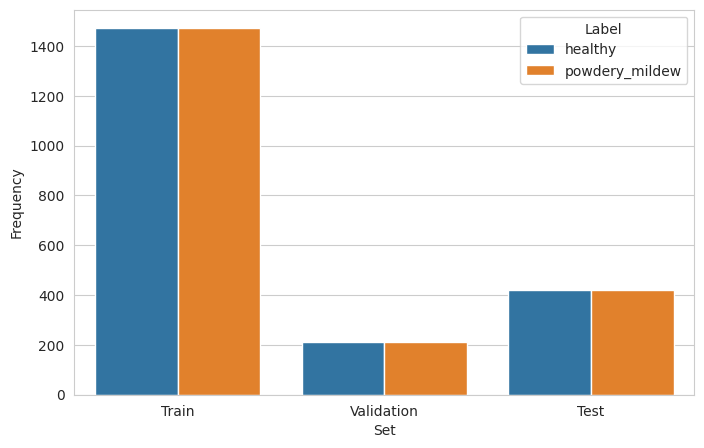

In [90]:
# Combine all labels from the datasets to get the unique labels
all_labels = pd.concat([train_df['label'], validation_df['label'], test_df['label']])
labels = all_labels.unique()

# Initialize an empty DataFrame
df_freq = pd.DataFrame([])

# Define the datasets
datasets = [('train', train_df), ('validation', validation_df), ('test', test_df)]

# Iterate over each dataset and label to count the occurrences
for dataset_name, dataset_df in datasets:
    # Initialize counts dictionary for each dataset
    dataset_counts = {label: 0 for label in labels}
    
    # Calculate counts for each label in the current dataset
    for label in labels:
        label_count = dataset_df[dataset_df['label'] == label].shape[0]
        dataset_counts[label] = label_count
    
    # Print dataset information
    print(f"{dataset_name.capitalize()}:")
    for label, label_count in dataset_counts.items():
        print(f"{label}: {label_count} images")

    # Append the counts to the df_freq DataFrame
    df_freq = df_freq.append(
        pd.DataFrame({'Set': dataset_name.capitalize(), 'Label': list(dataset_counts.keys()), 'Frequency': list(dataset_counts.values())}),
        ignore_index=True
    )

print("\n")

# Plot the frequency distribution
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/datasets_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

---

### ImageDataGenerator

In [91]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [92]:
data_dir = '/workspace/mildew-detection/inputs/datasets/cherry-leaves'
train_path = data_dir + '/train'
validation_path = data_dir + '/validation'
test_path = data_dir + '/test'

In [93]:
# Code from Walkthrough project 1 - Code Institute 

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255)

In [94]:
# Define image shape
image_shape = (100, 100)

# Set batch size
batch_size = 20

# Create the training set 
train_set = augmented_image_data.flow_from_directory(
    train_path,
    target_size=image_shape[:2], 
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

print(train_set.class_indices)

Found 2944 images belonging to 2 classes.
{'healthy': 0, 'powdery_mildew': 1}


In [95]:
# Code borrowed from Walkthrough project 1 - Code Institute
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [96]:
# Code borrowed from Walkthrough project 1 - Code Institute
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

Train set
Image shape: (100, 100, 3), Label: healthy


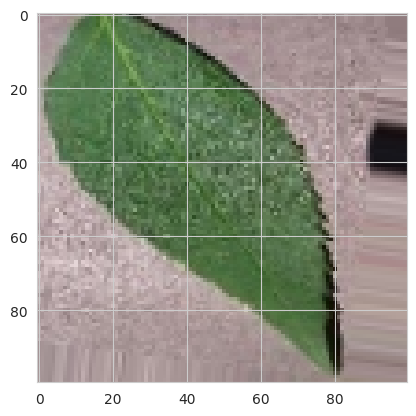

Train set
Image shape: (100, 100, 3), Label: healthy


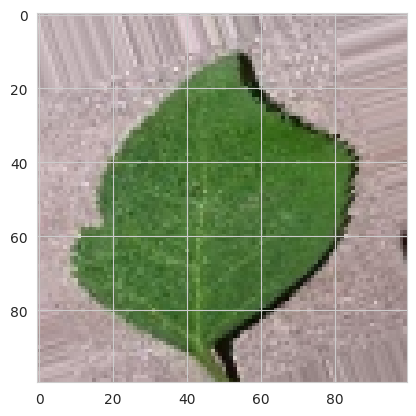

Train set
Image shape: (100, 100, 3), Label: healthy


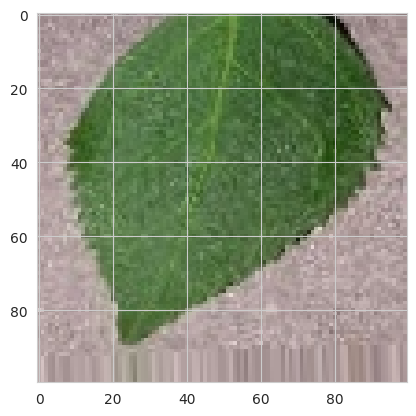

In [97]:
label_mapping = {0: 'healthy', 1: 'powdery_mildew'}
image_count = 0

imgs, labels = train_set.next() 
shuffled_indices = np.random.permutation(len(labels)) 
imgs_shuffled = imgs[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

for img, label in zip(imgs_shuffled, labels_shuffled):
    label_text = label_mapping[label]
    print("Train set") 
    print(f"Image shape: {img.shape}, Label: {label_text}")
    plt.imshow(img)
    plt.show()
    image_count += 1
    if image_count >= 3:
        break

## Plot augmented validation and test images

Validation set
Image shape: (100, 100, 3), Label: healthy


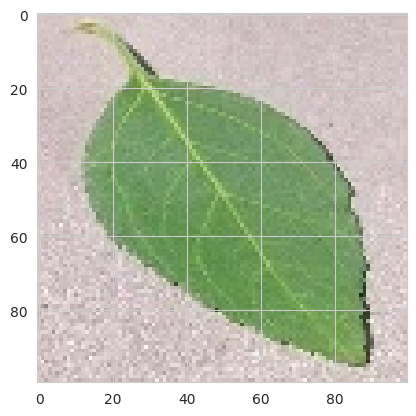

Validation set
Image shape: (100, 100, 3), Label: healthy


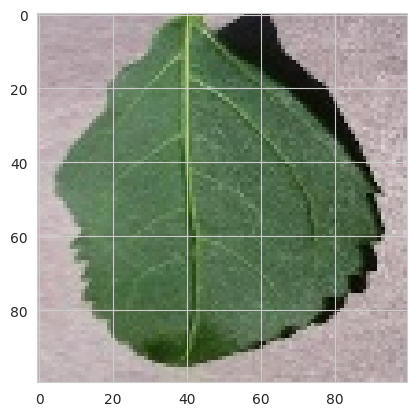

Validation set
Image shape: (100, 100, 3), Label: healthy


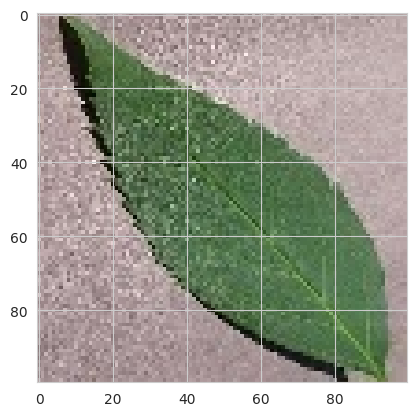

Test set
Image shape: (100, 100, 3), Label: healthy


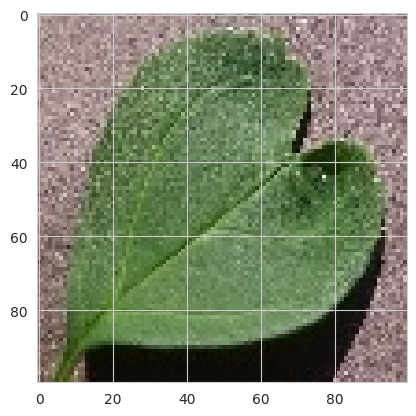

Test set
Image shape: (100, 100, 3), Label: healthy


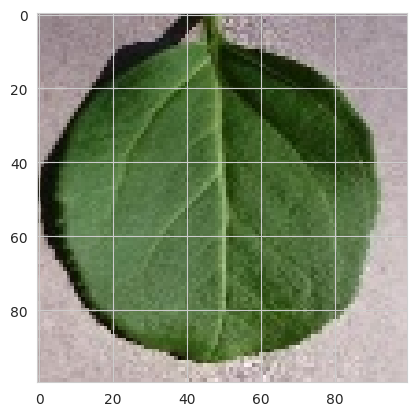

Test set
Image shape: (100, 100, 3), Label: healthy


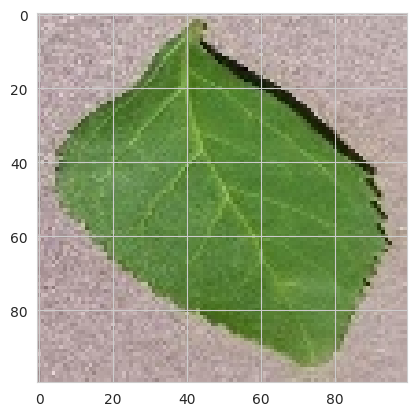

In [98]:
label_mapping = {0: 'healthy', 1: 'powdery_mildew'}
image_count = 0

imgs, labels = validation_set.next() 
shuffled_indices = np.random.permutation(len(labels)) 
imgs_shuffled = imgs[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

for img, label in zip(imgs_shuffled, labels_shuffled):
    label_text = label_mapping[label]
    print("Validation set") 
    print(f"Image shape: {img.shape}, Label: {label_text}")
    plt.imshow(img)
    plt.show()
    image_count += 1
    if image_count >= 3:
        break

label_mapping = {0: 'healthy', 1: 'powdery_mildew'}
image_count = 0

imgs, labels = test_set.next() 
shuffled_indices = np.random.permutation(len(labels))  # Shuffle indices
imgs_shuffled = imgs[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

for img, label in zip(imgs_shuffled, labels_shuffled):
    label_text = label_mapping[label]
    print("Test set") 
    print(f"Image shape: {img.shape}, Label: {label_text}")
    plt.imshow(img)
    plt.show()
    image_count += 1
    if image_count >= 3:
        break

## Save

In [99]:
import joblib

joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['/workspace/mildew-detection/outputs/v4/class_indices.pkl']

---

# Model creation

---

## ML Model

## Early stopping

In [100]:
# Code from Walkthrough project 1 - Code Institute

# Early stopping to prevent overfitting the model
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Model

In [101]:
# Code borrowed from Walkthrough project 1 - Code Institute and linx02 genderpredictor project.
# Adding in normalization layer, to help with faster convergence.

def create_model(hidden_layer_size, filters, dropout, learning_rate):
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=(100, 100, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Second convolutional layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Third convolutional layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

## Hyperparameter optimization

This part of the code aims to find the optimal hyperparameters for training the model using GridSearchCV

In [102]:
# Code from linx02 genderpredictor

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Wrap model in KerasClassifier for compatibility with scikit-learn
# Specified values below are required default values, these will not be used during GridSearch
model = KerasClassifier(build_fn=create_model, learning_rate=0.0, hidden_layer_size=0, filters=(0, 0, 0), dropout=(0, 0))

In [103]:
# Code from linx02 genderpredictor

# Define parameters to explore
param_grid = {
    'hidden_layer_size': [256, 512],
    'learning_rate': [0.01, 0.001],
    'filters': [(8, 16, 32), (16, 32, 64)],
    'dropout': [(0.1, 0.3), (0.25, 0.5)]
}

In [104]:
# Define GridSearchCV object
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=4,
)

In [105]:
# Fit to the training data
X_train, y_train = train_set.next()

search.fit(X_train, y_train, epochs=10, validation_data=validation_set, callbacks=[early_stop])

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6732 - accuracy: 0.7333 - val_loss: 0.6742 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.1834 - accuracy: 0.9333 - val_loss: 0.6550 - val_accuracy: 0.5643
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.1566 - accuracy: 0.9333 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0984 - accuracy: 0.9333 - val_loss: 0.7308 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 157ms/step - loss: 0.4233 - accuracy: 0.8000
Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6011 - accuracy: 0.6000 - val_loss: 0.9256 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.5027 - accuracy: 0.7333 - val_loss: 0.8505 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.4834 - ac

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9011f8dc10>,
             param_grid={'dropout': [(0.1, 0.3), (0.25, 0.5)],
                         'filters': [(8, 16, 32), (16, 32, 64)],
                         'hidden_layer_size': [256, 512],
                         'learning_rate': [0.01, 0.001]})

In [106]:
# Store the best parameters
best_params = search.best_params_
print("Best parameters:", best_params)

Best parameters: {'dropout': (0.25, 0.5), 'filters': (8, 16, 32), 'hidden_layer_size': 256, 'learning_rate': 0.01}


In [107]:
# Create new model using best params
model = create_model(dropout=best_params['dropout'], filters=best_params['filters'], hidden_layer_size=best_params['hidden_layer_size'], learning_rate=best_params['learning_rate'])
# Show summary of model
model.summary()

Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_397 (Conv2D)          (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_396 (MaxPoolin (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_398 (Conv2D)          (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_132 (Bat (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_397 (MaxPoolin (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_399 (Conv2D)          (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_398 (MaxPoolin (None, 10, 10, 64)     

In [108]:
# Train the model
hist = model.fit(train_set, epochs=10, steps_per_epoch=len(train_set), validation_data=validation_set, validation_steps=len(validation_set))

# Access training and validation loss 
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

Epoch 1/10
148/148 [==============================] - 35s 229ms/step - loss: 0.1536 - accuracy: 0.9504 - val_loss: 0.4536 - val_accuracy: 0.7571
Epoch 2/10
148/148 [==============================] - 31s 207ms/step - loss: 0.0869 - accuracy: 0.9745 - val_loss: 0.2817 - val_accuracy: 0.9857
Epoch 3/10
148/148 [==============================] - 30s 199ms/step - loss: 0.0433 - accuracy: 0.9857 - val_loss: 0.1048 - val_accuracy: 0.9690
Epoch 4/10
148/148 [==============================] - 31s 207ms/step - loss: 0.0304 - accuracy: 0.9929 - val_loss: 0.0424 - val_accuracy: 0.9857
Epoch 5/10
148/148 [==============================] - 23s 156ms/step - loss: 0.0473 - accuracy: 0.9878 - val_loss: 3.0610 - val_accuracy: 0.5857
Epoch 6/10
148/148 [==============================] - 38s 256ms/step - loss: 0.0323 - accuracy: 0.9901 - val_loss: 0.0306 - val_accuracy: 1.0000
Epoch 7/10
148/148 [==============================] - 31s 207ms/step - loss: 0.0240 - accuracy: 0.9932 - val_loss: 1.1202 - val_ac

In [109]:
# Save the model
model.save('/workspace/mildew-detection/outputs/trained_model.h5')

---

# Model Performace

---

## Model learning curve

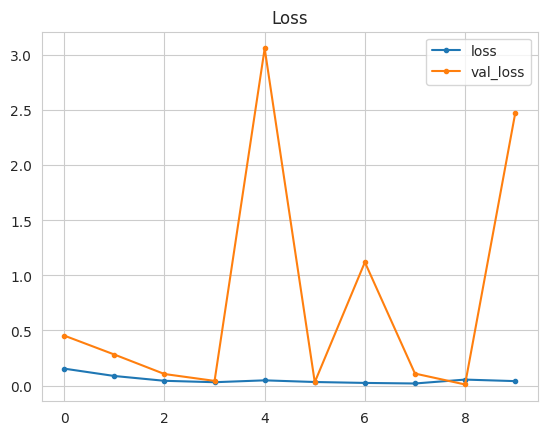

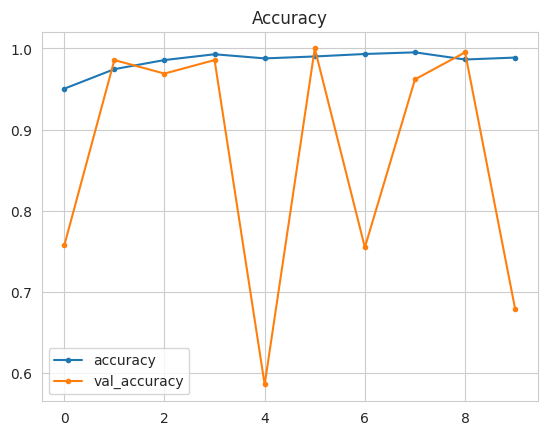

In [110]:
# Borrowed code from Walkthrough project 1 - Code Institute
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

In [111]:
from keras.models import load_model
model = load_model('/workspace/mildew-detection/outputs/trained_model.h5')

In [112]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 3s 76ms/step - loss: 2.2295 - accuracy: 0.6588


### Save evaluation pickle

In [113]:
output_dir = "/workspace/mildew-detection/outputs"

# Ensure the directory exists and save the file
os.makedirs(output_dir, exist_ok=True)
joblib.dump(evaluation, os.path.join(output_dir, "evaluation.pkl"))
print("Evaluation saved successfully.")

Evaluation saved successfully.


## Predict on new data

Load a random image as PIL

In [116]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# Image_shape
image_shape = (100, 100) 

# Base directory path
base_path = '/workspace/mildew-detection/inputs/datasets/cherry-leaves'

# Ensure that the base directory exists
if os.path.exists(base_path) and os.path.isdir(base_path):  
    subdirectories = [subdir for subdir in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, subdir))]
    
    # Loop through each subdirectory
    for subdir in subdirectories:
        subdir_path = os.path.join(base_path, subdir)
        
        files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
        
        if files:
            pointer = min(66, len(files) - 1)  # Ensure pointer does not exceed the length of files list
            
            # Load the image
            pil_image = image.load_img(os.path.join(subdir_path, files[pointer]),
                                       target_size=image_shape, color_mode='rgb')
            print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}, Label: {subdir}')
            
            # Convert the image to array and prepare for prediction
            my_image = image.img_to_array(pil_image)
            my_image = np.expand_dims(my_image, axis=0) / 255
            
            # Print the shape of the image array
            print(my_image.shape)
        else:
            print(f'No files found in subdirectory: {subdir_path}')
else:
    print(f'Base directory not found or is not a directory: {base_path}')

No files found in subdirectory: /workspace/mildew-detection/inputs/datasets/cherry-leaves/train
No files found in subdirectory: /workspace/mildew-detection/inputs/datasets/cherry-leaves/validation
No files found in subdirectory: /workspace/mildew-detection/inputs/datasets/cherry-leaves/test


Convert image to array and prepare for prediction

In [14]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [15]:
# Load model
model_file_path = '/workspace/mildew-detection/outputs/mildew_detection_model.h5'
model = load_model(model_file_path)

# Predict class probabilities
pred_proba = model.predict(my_image)[0, 0]

target_map = {0: 'healthy', 1: 'powdery_mildew'}
pred_class = target_map[int(pred_proba > 0.5)]

if pred_class == 'healthy':
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

2024-05-28 09:31:23.654377: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 09:31:24.673530: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1.0
powdery_mildew
